# Projet DATBI: M5 Forecasting

In [133]:
import pandas as pd
import numpy as np

## Partie 1: Visualisation des données

In [134]:
# Chargement des fichiers
calendar = pd.read_csv('calendar.csv')
sales_train_eval = pd.read_csv('sales_train_evaluation.csv', nrows=50)
sales_train_val = pd.read_csv('sales_train_validation.csv', nrows=50)
sample_submission = pd.read_csv('sample_submission.csv', nrows=50)
sell_prices = pd.read_csv('sell_prices.csv', nrows=50)

# Aperçu des données
datasets = {
    'calendar': calendar,
    'sales_train_evaluation': sales_train_eval,
    'sales_train_validation': sales_train_val,
    'sample_submission': sample_submission,
    'sell_prices': sell_prices
}



In [135]:
for name, df in datasets.items():
    print(f"==== {name} ====")
    print(df.head())
    print("\nInformations générales :")
    print(df.info())
    print("\nNombre de valeurs manquantes :")
    print(df.isnull().sum())
    print("\n\n")

==== calendar ====
         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data colum

Il semblerait qu'il n'y aie des données manquantes que dans calendar, dans les colonnes event_name_1 et event_name_2, event_type_1, event_type_2.  

On va simplement remplacer les NaN par "None.". On part donc du principe que si il n'y a pas de données c'est qu'il n'y avait pas d'évènements ce jour là. 

En effet comme il y a 90% de NaN dans ces colonnes, on peut penser que pour la grande majorité des jours c'est simplement qu'il n'y avait pas d'évènements.

Nous allons ensuite simplement merge les données

Visualisons tout de même la distribution des ventes

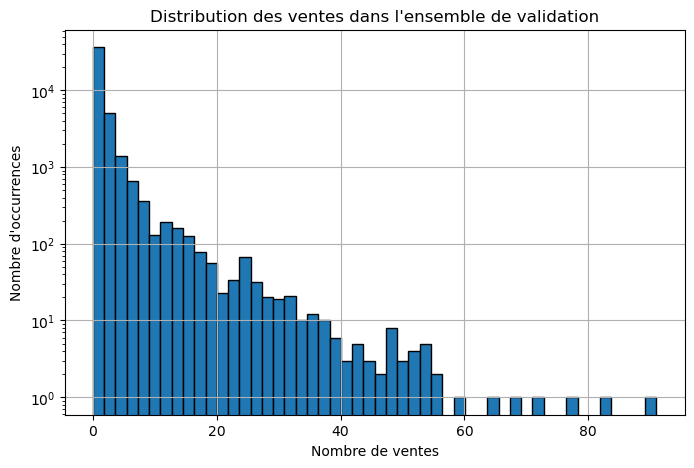

In [136]:
import matplotlib.pyplot as plt

# Plot de la distribution
plt.figure(figsize=(8, 5))
plt.hist(y_valid, bins=50, edgecolor='k')
plt.title("Distribution des ventes dans l'ensemble de validation")
plt.xlabel("Nombre de ventes")
plt.ylabel("Nombre d'occurrences")
plt.yscale('log')  # log-échelle pour mieux voir les petites fréquences
plt.grid(True)
plt.show()


## Partie 2: Traitement des données

In [137]:
from sklearn.preprocessing import LabelEncoder

On commence par appliquer une transformation cyclique pour le jour de la semaine (1 à 7) et le mois de l'année (1 à 12)

In [138]:
# Transformation cyclique pour le jour de la semaine (1-7)
calendar['wday_sin'] = np.sin(2 * np.pi * calendar['wday'] / 7)
calendar['wday_cos'] = np.cos(2 * np.pi * calendar['wday'] / 7)

# Pour le mois (1-12)
calendar['month_sin'] = np.sin(2 * np.pi * calendar['month'] / 12)
calendar['month_cos'] = np.cos(2 * np.pi * calendar['month'] / 12)


In [139]:
#création du dataset d'entrainement:

# 1. traitement des NaN de calendar
calendar['event_name_1'].fillna('None', inplace=True)
calendar['event_type_1'].fillna('None', inplace=True)

# 2. Préparer sales en format "long"
sales = sales_train_val.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                   var_name='d',
                   value_name='sales')

# 3. Merge avec calendar
sales = sales.merge(calendar, how='left', on='d')

# 4. Merge avec prices
sales = sales.merge(sell_prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])

# 5. Encodage label des catégories
for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'weekday']:
    sales[col] = LabelEncoder().fit_transform(sales[col])

# 6. Features (X) et target (y)
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'snap_CA', 'snap_TX', 'snap_WI',
            'event_name_1', 'event_type_1', 'weekday', 'month', 'year', 'sell_price']

X = sales[features]
y = sales['sales']

# 7. Séparer un train/test simple
X_train = X[sales['d'] < 'd_1913']
y_train = y[sales['d'] < 'd_1913']
X_valid = X[sales['d'] >= 'd_1913']
y_valid = y[sales['d'] >= 'd_1913']

C:\Users\alexa\AppData\Local\Temp\ipykernel_29280\2853399018.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calendar['event_name_1'].fillna('None', inplace=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_29280\2853399018.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

## Partie 3: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [141]:
# 8. Modèle Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 9. Prédiction
y_pred = model.predict(X_valid)

## Partie 4: Evaluation de la qualité du modèle

In [142]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [143]:
# 10. Évaluation
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Calcul du MAE sur la validation
mae = mean_absolute_error(y_valid, y_pred)

print(f"Validation MAE: {mae:.4f}")

Validation RMSE: 3.3860
Validation MAE: 1.3473


On souhaite à présent comparer la RMSE aux données pour connaitre la qualité de mon modèle

In [144]:
print("Moyenne des ventes (ensemble de validation) :", y_valid.mean())


Moyenne des ventes (ensemble de validation) : 1.1331995540691193


On compare avec la baseline "toujours prédire 0" car on a constaté beaucoup de ventes à 0 dans l'histogramme des ventes

In [145]:
# 1. Baseline "toujours prédire 0"
baseline_pred = np.zeros_like(y_valid)

# Calcul pour la baseline
baseline_rmse = np.sqrt(mean_squared_error(y_valid, baseline_pred))
baseline_mae = mean_absolute_error(y_valid, baseline_pred)

print(f"Baseline RMSE (toujours 0): {baseline_rmse:.4f}")
print(f"Baseline MAE (toujours 0): {baseline_mae:.4f}")

Baseline RMSE (toujours 0): 3.5726
Baseline MAE (toujours 0): 1.1332


Pour l'instant on a Random Forest RMSE< Baseline RMSE. Ainsi notre modèle comprend mieux les jours avec beaucoup de ventes. 
En revanche, Random Forest MAE> Baseline MAE ce qui traduit que notre modèle fait beaucoup d'erreurs sur les jours "classiques" à 0 ou 1 vente.

Le modèle de Random Forest utilisé jusqu'alors n'est donc pas excellent

## Partie 5: Amélioration du modèle

On va ajouter des lags et des moyennes glissantes. 
Ainsi cela permettra au random forest de:
- voir les ventes précédentes exactes (grâce aux lags)
- voir la tendance générale (grâce aux moyennes glissantes)

In [146]:
# Assurons-nous que sales est bien trié
sales = sales.sort_values(['id', 'd'])

# 1. Ajouter des lags
for lag in [1, 7, 14, 28]:
    sales[f'lag_{lag}'] = sales.groupby('id')['sales'].shift(lag)

# 2. Ajouter des rolling means
for window in [3, 7, 14, 28]:
    sales[f'rolling_mean_{window}'] = sales.groupby('id')['sales'].shift(1).rolling(window).mean()

# Enlever les lignes où il manque des lags ou des rollings
sales = sales.dropna(subset=[f'lag_{lag}' for lag in [1,7,14,28]] + 
                            [f'rolling_mean_{window}' for window in [3,7,14,28]])


In [147]:
features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
    'snap_CA', 'snap_TX', 'snap_WI',
    'event_name_1', 'event_type_1', 'weekday', 'month', 'year', 'sell_price',
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28'
]



In [148]:
X = sales[features]
y = sales['sales']

# Split en train/valid
X_train = X[sales['d'] < 'd_1913']
y_train = y[sales['d'] < 'd_1913']
X_valid = X[sales['d'] >= 'd_1913']
y_valid = y[sales['d'] >= 'd_1913']

# Modèle Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_valid)

print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_valid, y_pred)):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_valid, y_pred):.4f}")


Validation RMSE: 3.2512
Validation MAE: 1.3042


On a ainsi amélioré notre RMSE et MAE. Notre modèle est meilleure.

Mais on a toujours MAE modèle > 1.1332 donc en moyenne le modèle fait plus d'erreurs que de prédire 0 partout